# Fit a model of item similarity to inference task data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import dsmplot
from mindstorm import statplot
from tesser import tasks
from tesser import network
from tesser import model
from tesser import figures

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'model')
model_name = 'sr-g_a10'

## Load structure learning and inference task data

In [2]:
struct = tasks.load_struct(data_dir)
induct = tasks.load_induct(data_dir)

## Define inference model parameter search

In [3]:
# define free and fixed parameters
fixed = {'alpha': 0.1}
var_names = ['gamma', 'tau']
var_bounds = {
    'gamma': [0, 1],
    'tau': [0, 10],
}
question_param = None

# define similarity matrices
sim1_spec = {'alpha': 'alpha', 'gamma': 'gamma'}
sim2_spec = None

## Estimate best-fitting parameters

In [4]:
full_results = model.fit_induct(
    struct,
    induct,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
    n_job=6,
    n_rep=10,
)
full_results

,logl,n,k,alpha,gamma,tau
rep,,,,,,
0,-1356.573681,1554,2,0.1,1.0,1.337312
1,-1356.573681,1554,2,0.1,1.0,1.337323
2,-1356.573681,1554,2,0.1,1.0,1.337323
3,-1356.573681,1554,2,0.1,1.0,1.337324
4,-1356.573681,1554,2,0.1,1.0,1.337314
5,-1356.573681,1554,2,0.1,1.0,1.337325
6,-1356.573681,1554,2,0.1,1.0,1.337324
7,-1356.573681,1554,2,0.1,1.0,1.337324
8,-1356.573681,1554,2,0.1,1.0,1.337324


In [5]:
results = model.get_best_results(full_results)
results

,logl,n,k,alpha,gamma,tau
rep,,,,,,
3,-1356.573681,1554,2,0.1,1.0,1.337324


## Get fitted response probabilities for inference

In [6]:
temp = results.copy()
stats = model.get_fitted_prob(
    temp,
    induct,
    struct,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
)
stats

,subject,trial,trial_type,environment,community,cue,opt1,opt2,within,response,response_time,correct,prob_response,prob_correct
0,100,1,central,ocean,1,2,16,20,2,NaN,NaN,NaN,NaN,NaN
1,100,2,boundary2,desert,2,4,10,19,1,2.0,2.974157,0.0,0.467988,0.532012
2,100,3,central,desert,2,5,6,2,1,1.0,3.190848,1.0,0.578883,0.578883
3,100,4,central,ocean,1,2,9,19,2,2.0,3.373906,1.0,0.621355,0.621355
4,100,5,central,ocean,1,1,19,13,1,2.0,3.094699,0.0,0.355322,0.644678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,138,38,central,desert,2,8,9,21,1,2.0,2.025821,0.0,0.475404,0.524596
1550,138,39,central,forest,3,14,19,15,2,2.0,1.997691,1.0,0.572154,0.572154
1551,138,40,central,ocean,1,21,14,2,2,2.0,1.114204,1.0,0.618671,0.618671
1552,138,41,boundary1,forest,3,11,10,16,2,1.0,0.623270,0.0,0.424171,0.575829


## Mean probability by trial type

In [8]:
m = stats.groupby(['subject', 'trial_type'])[['correct', 'prob_correct']].mean().reset_index()
m['bias'] = (m['correct'] - .5) * 2
m['prob_bias'] = (m['prob_correct'] - .5) * 2
m['trial_type'] = m['trial_type'].map(
    {
        'central': 'Central',
        'boundary1': 'Boundary 1-Away',
        'boundary2': 'Boundary 2-Away',
    }
)

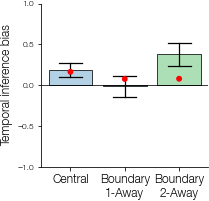

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
colors = figures.get_induct_colors()
# data
sns.barplot(
    data=m,
    x='trial_type',
    y='bias',
    hue='trial_type',
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    dodge=False,
    capsize=0.425,
    zorder=0,
    ax=ax,
)
# model fit
sns.pointplot(
    data=m,
    x='trial_type',
    y='prob_bias',
    color='r',
    linewidth=0.75,
    dodge=False,
    join=False,
    ci=None,
    zorder=1000,
    ax=ax,
)
plt.setp(ax.lines, zorder=50, linewidth=1.25, color='k', label=None)
plt.setp(ax.collections, zorder=100, label=None)
ax.set(
    ylabel='Temporal inference bias',
    ylim=(-1, 1),
    yticks=np.arange(-1, 1.5, .5),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.spines['left'].set_bounds(-1, 1)
ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(fig_dir, f'temporal_bias_model-{model_name}.pdf'))